In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
import os 
import matplotlib.image as mpimg
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import load_img, img_to_array
import pathlib
import numpy as np

In [21]:
for dirpath, dirnames, filenames in os.walk("../input/fruit-recognition"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [22]:
train_path = "dataset/train/"
test_path = "dataset/test/"

In [23]:
data_dir = pathlib.Path(train_path) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['apple' 'pear']


In [24]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 100)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

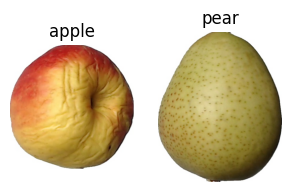

In [25]:
plt.figure(figsize = (15,15))
# View a random image from the training dataset for all classes
for i in range(2):
    plt.subplot(5,8,i+1)
    img = view_random_image(target_dir=train_path,
                        target_class=class_names[i])

In [26]:
train_val_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_val_data['path'].append(dirpath)
        train_val_data['filename'].append(f)
        train_val_data['label'].append(f.split('_')[0])

In [27]:
train_val_data_df = pd.DataFrame(train_val_data)
train_val_data_df.head()

,path,filename,label
0,dataset/train/apple,r1_208.jpg,r1
1,dataset/train/apple,r1_234.jpg,r1
2,dataset/train/apple,r1_12.jpg,r1
3,dataset/train/apple,r1_220.jpg,r1
4,dataset/train/apple,r0_190.jpg,r0


In [28]:
#Read test data and create a dataframe
test_data = {'path' : [],
       'filename': []}
for dirpath, dirnames, filenames in os.walk(test_path):
    for f in filenames:
        test_data['path'].append(dirpath)
        test_data['filename'].append(f)


In [29]:
test_data_df = pd.DataFrame(test_data)
test_data_df.head()

,path,filename
0,dataset/test/apple,r0_225.jpg
1,dataset/test/apple,r0_153.jpg
2,dataset/test/apple,r0_9.jpg
3,dataset/test/apple,r0_85.jpg
4,dataset/test/apple,r1_181.jpg


In [30]:
images = []
label = [] 

for _, d in train_val_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    images.append(img_to_array(img))
    label.append(d['label'])

In [31]:
images = np.array(images)
labels = np.array(label)
print(f"Complete data images shape: {images.shape} and label shape: {labels.shape}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (644,) + inhomogeneous part.

In [ ]:
test_images = []

for _, d in test_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    test_images.append(img_to_array(img))
    
test_images = np.array(test_images)
print(f"Test images shape: {test_images.shape} ")

In [ ]:
class_indices = dict(zip(class_names, range(len(class_names))))

labels_encoded = list(map(class_indices.get, labels))

#Convert to categorical data using tensorflow 
#labels to One-hot encoded
label_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(class_names), dtype='uint8')

In [ ]:
train_im, valid_im, train_lab, valid_lab = train_test_split(images, label_categorical, test_size=0.20, 
                                                            stratify=label_categorical, 
                                                            random_state=40, shuffle = True)

In [ ]:
print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

In [ ]:
print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices(test_images)

print ('check types; ', type(training_data), type(validation_data), type(test_data))

In [ ]:
### check using element_spec

print (training_data.element_spec)
print (validation_data.element_spec)

### as expected, tensors of image and original label shape


### create an iterator and turn it into numpy array 
train_iter = iter(training_data)
print(next(train_iter)[0].numpy(), '\n', next(train_iter)[1].numpy(), np.argmax(next(train_iter)[1].numpy()))

In [ ]:
train_iter_im, train_iter_label = next(iter(training_data))
print (train_iter_im.numpy().shape, train_iter_label.numpy().shape)

In [ ]:
train_iter_im1, train_iter_label1 = next(training_data.as_numpy_iterator())
print (train_iter_im1.shape, train_iter_label1.shape)

In [ ]:
check_list = list(training_data.as_numpy_iterator())
print (len(check_list), check_list[1])

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0]/255.)
    plt.xlabel(class_names[np.argmax(check_list[i][1])], fontsize=13)
plt.tight_layout()    
plt.show()

In [ ]:
rescale_data = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255.)
])

data_augmenation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
    #layers.experimental.preprocessing.RandomRotation(0.1)
])

In [ ]:
random_image_index = random.randint(0,len(train_im))
img = rescale_data(train_im[random_image_index])
img = data_augmenation(img)
plt.imshow(img)

In [ ]:
BATCH_SIZE = 128 
AUTOTUNE = tf.data.AUTOTUNE 

def prepare(ds, shuffle=False, augment = False, test = False):
    if test:
        ds = ds.map(lambda x: (rescale_data(x)), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (rescale_data(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
    
    #batch the data 
    ds = ds.batch(BATCH_SIZE)
    
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmenation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(training_data, shuffle = True, augment = True)
val_ds = prepare(validation_data)
test_ds = prepare(test_data, test=True)

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=5, 
                          kernel_size = 3,
                          activation = "relu",
                          input_shape = (100,100,3)),
    tf.keras.layers.MaxPool2D(pool_size =2,
                             padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model_1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [ ]:
model_1.summary()


In [ ]:
#Fit the model on training data 
history_1 = model_1.fit(train_ds,
                       epochs =25,
                       validation_data= val_ds)

In [ ]:
#loss and accuracy plot 
pd.DataFrame(history_1.history).plot()

In [ ]:
model_1.save('model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5')

In [ ]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0
    
    return img_preprocessed